# Team- LossLess Crew

# Multidimensional Personality Cluster Prediction


# 1. Importing Libraries and Loading the Dataset

We install additional libraries (CatBoost, XGBoost, LightGBM, TensorFlow) if needed,
then load `train.csv` and `test.csv`.

In [1]:
# Fix imbalanced-learn version for Kaggle
!pip uninstall -y imbalanced-learn
!pip install -q imbalanced-learn==0.11.0

# Now import
from imblearn.over_sampling import SMOTE


In [3]:
!pip install -q catboost xgboost lightgbm imbalanced-learn==0.11.0


In [5]:
import sys
import warnings
warnings.filterwarnings("ignore")

# Kaggle NOTE:
# Do NOT install TensorFlow / scikit-learn / scipy / protobuf using pip.
# They are already preinstalled with correct versions.

# If you need external libs, install ONLY these:
# !pip install -q catboost imbalanced-learn

# ----------------------------------------------------
# Safe imports (everything already installed on Kaggle)
# ----------------------------------------------------
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import KernelPCA
from sklearn.utils.class_weight import compute_class_weight

# classical ML models
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# oversampling
from imblearn.over_sampling import SMOTE

# boosting models
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# deep learning (works in Kaggle)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ----------------------------------------------------
# Dataset paths
# ----------------------------------------------------
train_path = '/home/nishith/Documents/7th_sem/ML/Post_Mid_Project/train.csv'
test_path  = '/home/nishith/Documents/7th_sem/ML/Post_Mid_Project/test.csv'

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

train_df.head()


2025-11-27 19:29:05.648213: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-27 19:29:05.799606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-27 19:29:05.840349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-27 19:29:05.856048: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-27 19:29:05.973350: I tensorflow/core/platform/cpu_feature_guar

,participant_id,age_group,identity_code,cultural_background,upbringing_influence,focus_intensity,consistency_score,external_guidance_usage,support_environment_score,hobby_engagement_level,physical_activity_index,creative_expression_index,altruism_score,personality_cluster
0,643,18,1,0,4,18.118879,24,1,0,1,1,0,0,Cluster_E
1,1753,16,1,3,2,2.469271,19,0,1,0,0,0,1,Cluster_E
2,1402,17,0,2,3,3.456401,25,0,0,0,0,0,0,Cluster_E
3,2033,17,1,0,1,15.838131,25,1,2,0,0,0,0,Cluster_E
4,991,16,0,0,0,1.045373,19,1,2,0,0,1,0,Cluster_E


# 2. Data Overview

 In this section we:
 - Quickly inspect shape, columns, and basic info
 - Look at the target distribution (`personality_cluster`)

In [6]:
print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)

print("\nColumns:", train_df.columns.tolist())

# Basic info
print("\nTrain info:")
print(train_df.info())

# Basic descriptive stats (numerical)
train_df.describe().T

Train shape: (1913, 14)
Test shape : (479, 13)

Columns: ['participant_id', 'age_group', 'identity_code', 'cultural_background', 'upbringing_influence', 'focus_intensity', 'consistency_score', 'external_guidance_usage', 'support_environment_score', 'hobby_engagement_level', 'physical_activity_index', 'creative_expression_index', 'altruism_score', 'personality_cluster']

Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   participant_id             1913 non-null   int64  
 1   age_group                  1913 non-null   int64  
 2   identity_code              1913 non-null   int64  
 3   cultural_background        1913 non-null   int64  
 4   upbringing_influence       1913 non-null   int64  
 5   focus_intensity            1913 non-null   float64
 6   consistency_score          1913 non-null   int64  
 7  

,count,mean,std,min,25%,50%,75%,max
participant_id,1913.0,1195.642446,687.474019,1.000000,613.000000,1189.000000,1787.000000,2392.000000
age_group,1913.0,16.456351,1.124705,15.000000,15.000000,16.000000,17.000000,18.000000
identity_code,1913.0,0.514375,0.499924,0.000000,0.000000,1.000000,1.000000,1.000000
cultural_background,1913.0,0.872974,1.031951,0.000000,0.000000,0.000000,2.000000,3.000000
upbringing_influence,1913.0,1.764245,0.988605,0.000000,1.000000,2.000000,2.000000,4.000000
focus_intensity,1913.0,9.748506,5.702764,0.008031,4.958649,9.518844,14.407464,19.968425
consistency_score,1913.0,14.618400,8.485326,0.000000,7.000000,15.000000,22.000000,29.000000
external_guidance_usage,1913.0,0.302143,0.459307,0.000000,0.000000,0.000000,1.000000,1.000000
support_environment_score,1913.0,2.140617,1.118309,0.000000,1.000000,2.000000,3.000000,4.000000
hobby_engagement_level,1913.0,0.380031,0.485521,0.000000,0.000000,0.000000,1.000000,1.000000


personality_cluster
Cluster_E    974
Cluster_D    328
Cluster_C    306
Cluster_B    220
Cluster_A     85
Name: count, dtype: int64


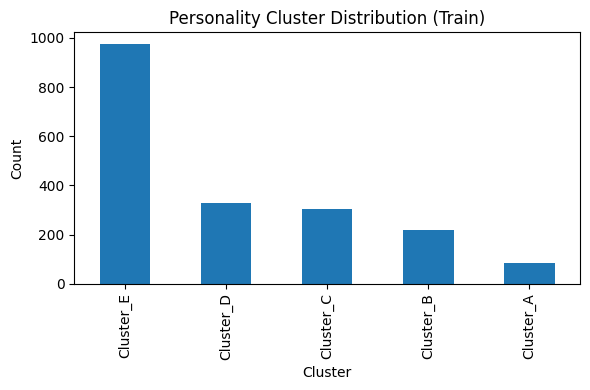

In [7]:
# Target distribution
target_col = 'personality_cluster'
print(train_df[target_col].value_counts())

plt.figure(figsize=(6,4))
train_df[target_col].value_counts().plot(kind='bar')
plt.title("Personality Cluster Distribution (Train)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3. Handling Missing Values

We'll:
- Check missing values per column
- (For later in preprocessing) use:
- `SimpleImputer(strategy='median')` for numeric
- `SimpleImputer(strategy='most_frequent')` for categorical

In [8]:

missing_train = train_df.isna().sum().sort_values(ascending=False)
missing_test = test_df.isna().sum().sort_values(ascending=False)

print("Missing values in train:")
print(missing_train[missing_train > 0])

print("\nMissing values in test:")
print(missing_test[missing_test > 0])

Missing values in train:
Series([], dtype: int64)

Missing values in test:
Series([], dtype: int64)


# 4. Handling Duplicate Values

We detect and remove exact duplicate rows in the training data
(if any). Duplicates in test don't matter for training.

In [9]:
dup_count = train_df.duplicated().sum()
print(f"Number of duplicate rows in train: {dup_count}")

if dup_count > 0:
    train_df = train_df.drop_duplicates().reset_index(drop=True)
    print("Duplicates removed. New train shape:", train_df.shape)

Number of duplicate rows in train: 0


# 5. Exploratory Data Analysis (EDA)

We will:
- Look at distributions of continuous-like features
- Use boxplots to inspect outliers
- Plot a correlation heatmap among numeric features


In [10]:
# Identify basic numeric columns (excluding ids and target)
id_cols = ['participant_id', 'record_code']
numeric_cols = [
    col for col in train_df.columns
    if (train_df[col].dtype != 'object') and (col not in id_cols + [target_col])
]

categorical_cols = [
    col for col in train_df.columns
    if (train_df[col].dtype == 'object') and (col not in [target_col])
]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numeric columns: ['age_group', 'identity_code', 'cultural_background', 'upbringing_influence', 'focus_intensity', 'consistency_score', 'external_guidance_usage', 'support_environment_score', 'hobby_engagement_level', 'physical_activity_index', 'creative_expression_index', 'altruism_score']
Categorical columns: []


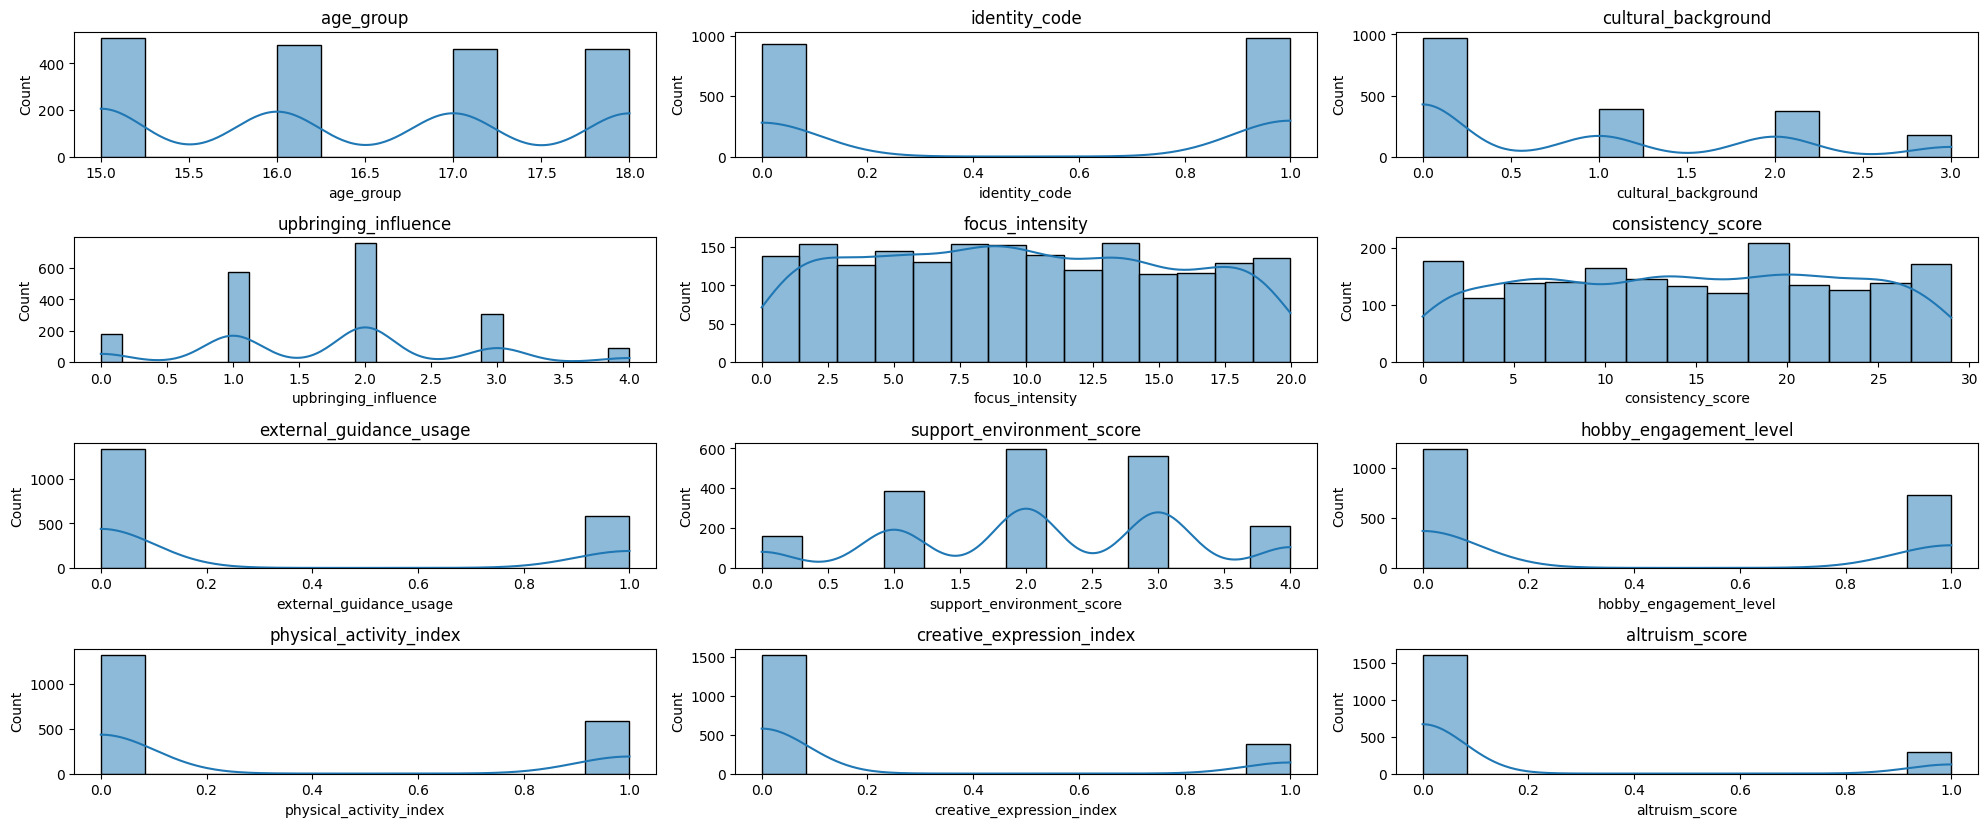

In [11]:
# Histograms for numeric features
n_num = len(numeric_cols)
plt.figure(figsize=(4 * ((n_num//3)+1), 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot((n_num//3)+1, 3, i)
    sns.histplot(train_df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

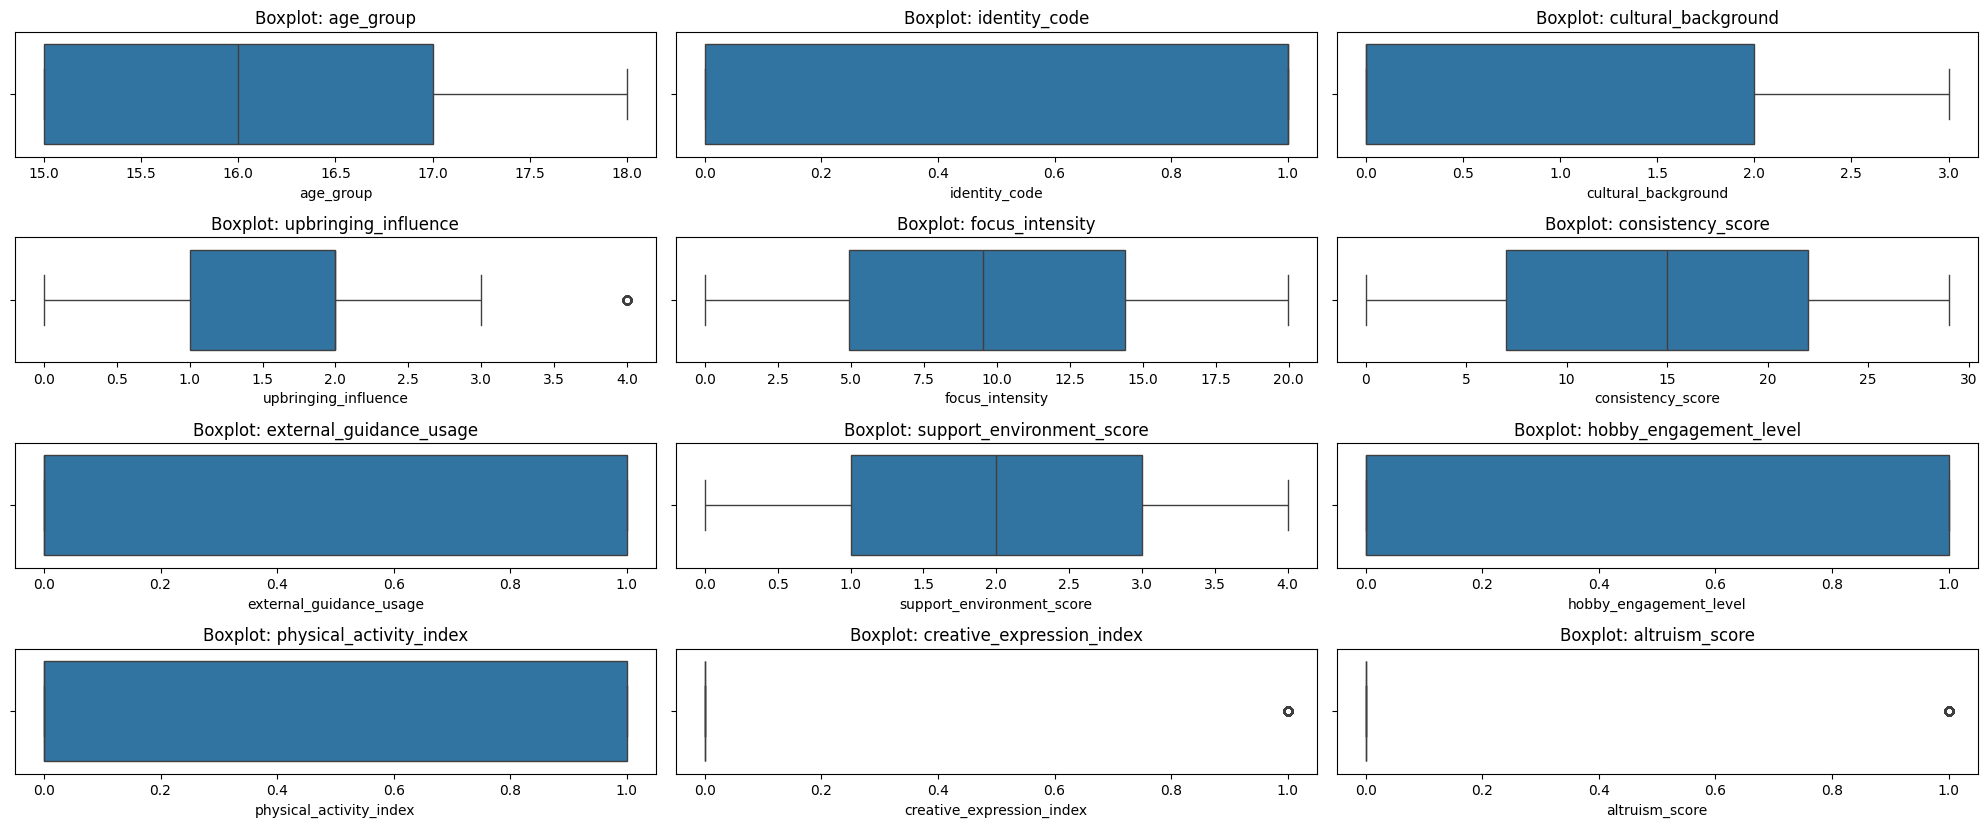

In [12]:
# Boxplots for outlier detection
plt.figure(figsize=(4 * ((n_num//3)+1), 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot((n_num//3)+1, 3, i)
    sns.boxplot(x=train_df[col])
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

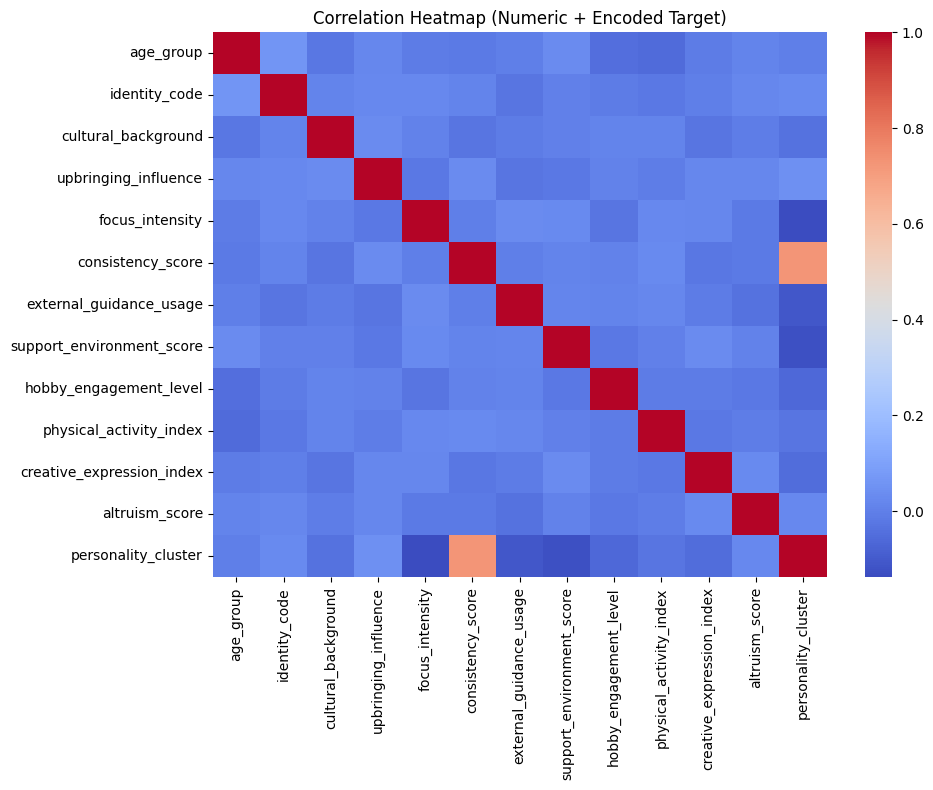

In [13]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = train_df[numeric_cols + [target_col]].copy()
# Encode target for corr
le_temp = LabelEncoder()
corr[target_col] = le_temp.fit_transform(corr[target_col])

corr_matrix = corr.corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric + Encoded Target)")
plt.tight_layout()
plt.show()

# 6. Data Preprocessing

Steps:
1. Drop ID-like / non-predictive columns (`participant_id`, `record_code`).
2. Encode `personality_cluster` with `LabelEncoder`.
3. Use a `ColumnTransformer` with:
   - Numeric: median imputation + StandardScaler
   - Categorical: most frequent imputation + OneHotEncoder

Later, we add **advanced geometric features** used by your best solution:
- Interaction features:
  - `total_engagement`
  - `focus_consistency`
  - `support_guidance`
- Geometric features from:
  - KMeans distances
  - GMM probabilities

These geometric features are particularly useful for **CatBoost**, **XGBoost**, **LGBM**, and the **stacking** model.


In [14]:
# Make a working copy
df = train_df.copy()
test = test_df.copy()

# Separate target
y_raw = df[target_col].copy()
X_raw = df.drop(columns=[target_col])

# Encode target
le = LabelEncoder()
y = le.fit_transform(y_raw)

print("Classes:", le.classes_)
num_classes = len(le.classes_)

Classes: ['Cluster_A' 'Cluster_B' 'Cluster_C' 'Cluster_D' 'Cluster_E']


In [16]:
# Drop non-predictive ids for modeling (ignore missing ones)
drop_cols = ['participant_id', 'record_code']

X_basic = X_raw.drop(columns=drop_cols, errors="ignore")
X_test_basic = test.drop(columns=drop_cols, errors="ignore")

# Recompute numeric & categorical sets on basic X
numeric_cols_basic = [
    col for col in X_basic.columns
    if X_basic[col].dtype != 'object'
]

categorical_cols_basic = [
    col for col in X_basic.columns
    if X_basic[col].dtype == 'object'
]

numeric_cols_basic, categorical_cols_basic


(['age_group',
  'identity_code',
  'cultural_background',
  'upbringing_influence',
  'focus_intensity',
  'consistency_score',
  'external_guidance_usage',
  'support_environment_score',
  'hobby_engagement_level',
  'physical_activity_index',
  'creative_expression_index',
  'altruism_score'],
 [])

In [17]:
# %%
from sklearn.preprocessing import OneHotEncoder

# Basic preprocessing pipeline (used by baseline models)
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_basic = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols_basic),
        ("cat", categorical_transformer, categorical_cols_basic)
    ]
)

# Fit-transform once so we can reuse this transformed feature matrix for classical models
X_basic_processed = preprocessor_basic.fit_transform(X_basic)
X_test_basic_processed = preprocessor_basic.transform(X_test_basic)

print("Processed basic feature shape:", X_basic_processed.shape)


Processed basic feature shape: (1913, 12)


## 6.1 Advanced Feature Engineering (Geometry + Interactions)

For the stronger ensembles, we use a more specialized feature set:

- New interaction features:
  - `total_engagement = hobby + physical_activity + creative + altruism`
  - `focus_consistency = focus_intensity * consistency_score`
  - `support_guidance = support_environment_score + external_guidance_usage`

- Geometric features:
  - KMeans distances to 5 cluster centers
  - GMM probabilities for 5 components

These give the model a sense of the “shape” / manifold of the data.

In [20]:
# Define random state for reproducibility
RANDOM_STATE = 42

def create_advanced_features(train_df_full, test_df_full, target_col_name="personality_cluster"):
    train_df = train_df_full.copy()
    test_df = test_df_full.copy()
    
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    
    if target_col_name in train_df.columns:
        train_df = train_df.drop(columns=[target_col_name])
        
    full = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
    
    # Interaction features
    full['total_engagement'] = (
        full['hobby_engagement_level'] +
        full['physical_activity_index'] +
        full['creative_expression_index'] +
        full['altruism_score']
    )
    full['focus_consistency'] = full['focus_intensity'] * full['consistency_score']
    full['support_guidance'] = full['support_environment_score'] + full['external_guidance_usage']
    
    # Geometric features
    geom_cols = [
        'focus_intensity',
        'consistency_score',
        'support_environment_score',
        'total_engagement',
        'focus_consistency'
    ]
    
    pt = PowerTransformer(method='yeo-johnson')
    scaled_geom = pt.fit_transform(full[geom_cols])
    
    # --------------------
    # KMeans clustering
    # --------------------
    kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init=10)
    kmeans.fit(scaled_geom)
    dists = kmeans.transform(scaled_geom)
    for i in range(5):
        full[f'dist_km_{i}'] = dists[:, i]
    
    # --------------------
    # GMM probabilistic clustering
    # --------------------
    gmm = GaussianMixture(n_components=5, random_state=RANDOM_STATE, n_init=3)
    gmm.fit(scaled_geom)
    probs = gmm.predict_proba(scaled_geom)
    for i in range(5):
        full[f'prob_gmm_{i}'] = probs[:, i]
    
    # Split back
    train_X = full[full['is_train'] == 1].drop(columns=['is_train'])
    test_X = full[full['is_train'] == 0].drop(columns=['is_train'])
    
    return train_X, test_X

# Run feature generator
X_adv, X_test_adv = create_advanced_features(train_df, test_df, target_col_name=target_col)

# Drop ID from modeling
X_adv = X_adv.drop(columns=['participant_id'])
X_test_adv = X_test_adv.drop(columns=['participant_id'])

# Scale advanced features
scaler_adv = StandardScaler()
X_adv_scaled = scaler_adv.fit_transform(X_adv)
X_test_adv_scaled = scaler_adv.transform(X_test_adv)


# 7. Train/Validation Split

For model comparison we use a single **stratified train/validation split**
(later, some models use multi-fold cross-validation).



In [21]:
# %%
X_train_basic, X_val_basic, y_train_basic, y_val_basic = train_test_split(
    X_basic_processed, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X_train_adv, X_val_adv, y_train_adv, y_val_adv = train_test_split(
    X_adv_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Basic   train/val shapes:", X_train_basic.shape, X_val_basic.shape)
print("Advanced train/val shapes:", X_train_adv.shape, X_val_adv.shape)


Basic   train/val shapes: (1530, 12) (383, 12)
Advanced train/val shapes: (1530, 25) (383, 25)


# 8. Model Comparison & Hyperparameter Tuning

Here we first focus on **classical models**:

- Logistic Regression  
- Support Vector Machine (SVM)  
- Neural Network (MLPClassifier – *not* the Keras deep stack yet)

### Experiment Protocol (kept constant across these models)

- Input: `X_basic_processed` (basic preprocessing)  
- 80/20 stratified train/validation split  
- Macro F1 as primary metric  
- Reasonable hyperparameter grids (small but meaningful)

We will also later build tree-based and boosted models with **advanced features**.


## 8.1 Logistic Regression

In [22]:

log_reg = LogisticRegression(
    max_iter=200,
    multi_class="multinomial",
    solver="lbfgs"
)

log_reg_param_grid = {
    "C": [0.1, 1.0, 5.0],
    "penalty": ["l2"]
}

log_reg_grid = GridSearchCV(
    estimator=log_reg,
    param_grid=log_reg_param_grid,
    cv=5,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=0
)

log_reg_grid.fit(X_train_basic, y_train_basic)
y_pred_lr = log_reg_grid.predict(X_val_basic)

print("Best Logistic Regression params:", log_reg_grid.best_params_)
print("LogReg Macro F1:", f1_score(y_val_basic, y_pred_lr, average="macro"))
print("\nClassification Report (LogReg):\n",
      classification_report(y_val_basic, y_pred_lr, target_names=le.classes_))


Best Logistic Regression params: {'C': 5.0, 'penalty': 'l2'}
LogReg Macro F1: 0.5429854663704562

Classification Report (LogReg):
               precision    recall  f1-score   support

   Cluster_A       0.50      0.12      0.19        17
   Cluster_B       0.51      0.50      0.51        44
   Cluster_C       0.58      0.61      0.59        61
   Cluster_D       0.60      0.48      0.54        66
   Cluster_E       0.84      0.94      0.89       195

    accuracy                           0.72       383
   macro avg       0.61      0.53      0.54       383
weighted avg       0.70      0.72      0.71       383



## 8.2 SVM

In [23]:
# %%
svm_clf = SVC(probability=False, decision_function_shape="ovr")

svm_param_grid = {
    "C": [0.5, 1.0, 2.0],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]
}

svm_grid = GridSearchCV(
    estimator=svm_clf,
    param_grid=svm_param_grid,
    cv=3,                  # 3-fold to save some time
    scoring="f1_macro",
    n_jobs=-1,
    verbose=0
)

svm_grid.fit(X_train_basic, y_train_basic)
y_pred_svm = svm_grid.predict(X_val_basic)

print("Best SVM params:", svm_grid.best_params_)
print("SVM Macro F1:", f1_score(y_val_basic, y_pred_svm, average="macro"))
print("\nClassification Report (SVM):\n",
      classification_report(y_val_basic, y_pred_svm, target_names=le.classes_))


Best SVM params: {'C': 0.5, 'gamma': 'scale', 'kernel': 'linear'}
SVM Macro F1: 0.5233309937706125

Classification Report (SVM):
               precision    recall  f1-score   support

   Cluster_A       0.00      0.00      0.00        17
   Cluster_B       0.51      0.59      0.55        44
   Cluster_C       0.62      0.56      0.59        61
   Cluster_D       0.57      0.59      0.58        66
   Cluster_E       0.87      0.93      0.90       195

    accuracy                           0.73       383
   macro avg       0.51      0.53      0.52       383
weighted avg       0.70      0.73      0.72       383



## 8.3 Neural Network (Sklearn MLP)

In [24]:
# %%
mlp = MLPClassifier(max_iter=300, random_state=RANDOM_STATE)

mlp_param_grid = {
    "hidden_layer_sizes": [(64,), (128,), (128, 64)],
    "alpha": [1e-4, 1e-3],
    "learning_rate_init": [1e-3, 5e-4]
}

mlp_grid = GridSearchCV(
    estimator=mlp,
    param_grid=mlp_param_grid,
    cv=3,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=0
)

mlp_grid.fit(X_train_basic, y_train_basic)
y_pred_mlp = mlp_grid.predict(X_val_basic)

print("Best MLP params:", mlp_grid.best_params_)
print("MLP Macro F1:", f1_score(y_val_basic, y_pred_mlp, average="macro"))
print("\nClassification Report (MLP):\n",
      classification_report(y_val_basic, y_pred_mlp, target_names=le.classes_))


/home/nishith/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nishith/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nishith/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nishith/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/nishith/.local/lib/python3.10/site-pac

Best MLP params: {'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001}
MLP Macro F1: 0.5430957520468416

Classification Report (MLP):
               precision    recall  f1-score   support

   Cluster_A       0.50      0.24      0.32        17
   Cluster_B       0.50      0.43      0.46        44
   Cluster_C       0.52      0.52      0.52        61
   Cluster_D       0.50      0.53      0.51        66
   Cluster_E       0.87      0.92      0.89       195

    accuracy                           0.70       383
   macro avg       0.58      0.53      0.54       383
weighted avg       0.69      0.70      0.69       383



## 8.4 Tree-Based Models (Using Advanced Features)

Now we use the **stronger engineered feature set** (`X_adv_scaled`) with:

- Random Forest  
- KNN  
- XGBoost  
- LightGBM  
- CatBoost  

These are also the base learners for the **Diversity Stacking** model.


In [25]:
def eval_model(model, X_tr, y_tr, X_va, y_va, name="model"):
    model.fit(X_tr, y_tr)
    preds = model.predict(X_va)
    score = f1_score(y_va, preds, average="macro")
    print(f"{name} Macro F1: {score:.4f}")
    return score, preds


In [26]:
# %%
# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_score, _ = eval_model(rf_clf, X_train_adv, y_train_adv, X_val_adv, y_val_adv, "RandomForest")

# KNN
knn_clf = KNeighborsClassifier(
    n_neighbors=15,
    weights="distance",
    n_jobs=-1
)
knn_score, _ = eval_model(knn_clf, X_train_adv, y_train_adv, X_val_adv, y_val_adv, "KNN")


RandomForest Macro F1: 0.6140
KNN Macro F1: 0.4645


In [27]:
# %%
# XGBoost
xgb_clf = XGBClassifier(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="multi:softmax",
    num_class=num_classes,
    eval_metric="mlogloss",
    random_state=RANDOM_STATE,
    tree_method="hist"
)
xgb_score, _ = eval_model(xgb_clf, X_train_adv, y_train_adv, X_val_adv, y_val_adv, "XGBoost")

# LightGBM
lgbm_clf = LGBMClassifier(
    n_estimators=600,
    learning_rate=0.03,
    max_depth=6,
    num_leaves=25,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)
lgbm_score, _ = eval_model(lgbm_clf, X_train_adv, y_train_adv, X_val_adv, y_val_adv, "LightGBM")

# CatBoost (Balanced)
cat_clf_bal = CatBoostClassifier(
    iterations=800,
    learning_rate=0.03,
    depth=6,
    loss_function="MultiClass",
    auto_class_weights="Balanced",
    random_seed=RANDOM_STATE,
    verbose=0
)
cat_score, _ = eval_model(cat_clf_bal, X_train_adv, y_train_adv, X_val_adv, y_val_adv, "CatBoost Balanced")


XGBoost Macro F1: 0.6158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3038
[LightGBM] [Info] Number of data points in the train set: 1530, number of used features: 25
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

# 9. Advanced Experiments & Ensembles

Here we implement the **full set of experiments** described:

### The Winners
1. **Diversity Stacking + Quota System** (~0.582)  
2. **Balanced CatBoost** (~0.575)

### The "Almost" Solutions
- Ordinal-Enriched Stacking  
- One-vs-Rest specialist models  
- Manifold learning (Kernel PCA)

### The Failures (what did *not* work)
- Pseudo-labeling  
- Two-stage cascade  
- SMOTE  
- Pure ordinal regression

For runtime reasons, some experiments are toggled with flags so you can turn them on/off.


## 9.1 Diversity Stacking + Quota System (Winner)

In [28]:
# %%
# Use advanced features (scaled)
X_full_adv = X_adv_scaled
X_test_full_adv = X_test_adv_scaled
y_full = y

# Compute class weights for NN
classes = np.unique(y_full)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_full)
class_weights_dict = dict(zip(classes, weights))
class_weights_dict


{0: 4.501176470588235,
 1: 1.739090909090909,
 2: 1.250326797385621,
 3: 1.1664634146341464,
 4: 0.39281314168377823}

In [29]:
# %%
def create_keras_nn(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation='relu'),
        BatchNormalization(),

        Dense(output_dim, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [32]:
# %%
import gc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


print("\n--- Training Deep Diversity Stack (CatBoost / XGB / LGBM / RF / KNN / Keras NN) ---")

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

tree_models = {
    'catboost': CatBoostClassifier(
        iterations=1200,
        learning_rate=0.02,
        depth=6,
        loss_function='MultiClass',
        verbose=0,
        random_seed=RANDOM_STATE
    ),
    'xgboost': XGBClassifier(
        n_estimators=1000,
        learning_rate=0.02,
        max_depth=5,
        subsample=0.7,
        colsample_bytree=0.6,
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric="mlogloss",
        random_state=RANDOM_STATE,
        tree_method="hist"
    ),
    'lightgbm': LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.02,
        max_depth=6,
        num_leaves=25,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'rf': RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'knn': KNeighborsClassifier(
        n_neighbors=15,
        weights='distance',
        n_jobs=-1
    )
}

n_models = len(tree_models) + 1   # +1 for NN
level1_train = np.zeros((len(X_full_adv), num_classes * n_models))
level1_test = np.zeros((len(X_test_full_adv), num_classes * n_models))

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_full_adv, y_full)):
    print(f"Fold {fold+1}/10")
    X_tr, X_val = X_full_adv[tr_idx], X_full_adv[val_idx]
    y_tr, y_val = y_full[tr_idx], y_full[val_idx]
    
    y_tr_oh = to_categorical(y_tr, num_classes=num_classes)
    y_val_oh = to_categorical(y_val, num_classes=num_classes)
    
    current_col = 0
    # Tree models + KNN
    for name, model in tree_models.items():
        model.fit(X_tr, y_tr)
        level1_train[val_idx, current_col:current_col+num_classes] = model.predict_proba(X_val)
        level1_test[:, current_col:current_col+num_classes] += model.predict_proba(X_test_full_adv) / skf.n_splits
        current_col += num_classes
    
    # Keras NN
    nn = create_keras_nn(X_tr.shape[1], num_classes)
    es = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=0)
    rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5, verbose=0)
    sample_weights = np.array([class_weights_dict[yy] for yy in y_tr])
    
    nn.fit(
        X_tr, y_tr_oh,
        validation_data=(X_val, y_val_oh),
        epochs=100,
        batch_size=32,
        callbacks=[es, rlr],
        sample_weight=sample_weights,
        verbose=0
    )
    
    level1_train[val_idx, current_col:current_col+num_classes] = nn.predict(X_val, verbose=0)
    level1_test[:, current_col:current_col+num_classes] += nn.predict(X_test_full_adv, verbose=0) / skf.n_splits
    
    tf.keras.backend.clear_session()
    del nn
    gc.collect()



--- Training Deep Diversity Stack (CatBoost / XGB / LGBM / RF / KNN / Keras NN) ---
Fold 1/10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.088605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3055
[LightGBM] [Info] Number of data points in the train set: 1721, number of used features: 25
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [33]:
# %%
# Meta-learner: RidgeClassifierCV
meta_model = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], class_weight='balanced')
meta_model.fit(level1_train, y_full)

stack_preds = meta_model.predict(level1_train)
stack_macro_f1 = f1_score(y_full, stack_preds, average="macro")
print(f"\nDeep Stack (before quota) CV Macro F1 (on level1_train): {stack_macro_f1:.4f}")



Deep Stack (before quota) CV Macro F1 (on level1_train): 0.6121


In [34]:
# %%
# Turn meta decision function into pseudo-probabilities
d_test = meta_model.decision_function(level1_test)
# Numerical stability
d_test_shift = d_test - d_test.max(axis=1, keepdims=True)
final_probs = np.exp(d_test_shift)
final_probs = final_probs / final_probs.sum(axis=1, keepdims=True)

final_probs.shape


(479, 5)

In [35]:
# %%
# Compute train class distribution & derive target quotas for test set
train_counts = pd.Series(y_full).value_counts().sort_index()
train_proportions = train_counts / train_counts.sum()

n_test = X_test_full_adv.shape[0]
quota_counts = (train_proportions * n_test).round().astype(int)

print("Train class counts:", train_counts.to_dict())
print("Test quota counts :", quota_counts.to_dict())

# In case rounding doesn't perfectly match test size, adjust:
diff = n_test - quota_counts.sum()
# Add/subtract from largest class
if diff != 0:
    max_cls = quota_counts.idxmax()
    quota_counts[max_cls] += diff

print("Adjusted test quota counts:", quota_counts.to_dict())


Train class counts: {0: 85, 1: 220, 2: 306, 3: 328, 4: 974}
Test quota counts : {0: 21, 1: 55, 2: 77, 3: 82, 4: 244}
Adjusted test quota counts: {0: 21, 1: 55, 2: 77, 3: 82, 4: 244}


In [36]:
# %%
results = pd.DataFrame(final_probs, columns=range(num_classes))
results["assigned_class"] = -1

processing_order = list(range(num_classes))  # you can tune this if needed

for cls in processing_order:
    spots_needed = quota_counts[cls]
    available_rows = results[results["assigned_class"] == -1]
    
    # highest probability rows for this class
    best_candidates = available_rows.sort_values(by=cls, ascending=False).head(spots_needed)
    results.loc[best_candidates.index, "assigned_class"] = cls

# Any leftover (just in case of misalignment) – assign argmax
unassigned_mask = results["assigned_class"] == -1
if unassigned_mask.any():
    print("Fixing", unassigned_mask.sum(), "unassigned rows")
    results.loc[unassigned_mask, "assigned_class"] = results.loc[unassigned_mask, range(num_classes)].idxmax(axis=1)


In [37]:
# %%
# Final labels from best stack + quota system
final_labels = le.inverse_transform(results['assigned_class'].astype(int).values)

submission_stack_quota = pd.DataFrame({
    "participant_id": test_df["participant_id"],
    "personality_cluster": final_labels
})

submission_stack_quota["personality_cluster"].value_counts()


personality_cluster
Cluster_E    244
Cluster_D     82
Cluster_C     77
Cluster_B     55
Cluster_A     21
Name: count, dtype: int64

## 9.2 Balanced CatBoost (Single-Model Winner)

We already trained a **Balanced CatBoost** above (`cat_clf_bal`).  
For completeness, here we refit on the full advanced data and produce predictions.


In [38]:
# %%
cat_bal_full = CatBoostClassifier(
    iterations=800,
    learning_rate=0.03,
    depth=6,
    loss_function="MultiClass",
    auto_class_weights="Balanced",
    random_seed=RANDOM_STATE,
    verbose=0
)

cat_bal_full.fit(X_full_adv, y_full)
cat_test_probs = cat_bal_full.predict_proba(X_test_full_adv)
cat_test_preds = cat_bal_full.predict(X_test_full_adv)

cat_submission = pd.DataFrame({
    "participant_id": test_df["participant_id"],
    "personality_cluster": le.inverse_transform(cat_test_preds.astype(int))
})

cat_submission["personality_cluster"].value_counts()


personality_cluster
Cluster_E    225
Cluster_D    105
Cluster_C     73
Cluster_B     62
Cluster_A     14
Name: count, dtype: int64

## 9.3 Ordinal-Enriched Stacking

Idea: Map clusters to ordinal scores (0–4), train a regressor,  
then use the predicted *score* as an extra feature for the stack.

Here we just sketch a simple version:


In [39]:
# %%
RUN_ORDINAL_STACK = False  # set True if you want to actually run

if RUN_ORDINAL_STACK:
    # Map classes to ordinal (0..4)
    class_to_ord = {c: i for i, c in enumerate(sorted(classes))}
    y_ord = np.array([class_to_ord[yy] for yy in y_full])
    
    from sklearn.ensemble import GradientBoostingRegressor
    
    gbr = GradientBoostingRegressor(random_state=RANDOM_STATE)
    gbr.fit(X_full_adv, y_ord)
    
    ord_train = gbr.predict(X_full_adv).reshape(-1, 1)
    ord_test = gbr.predict(X_test_full_adv).reshape(-1, 1)
    
    # Concatenate to level1 / advanced features (simplified variant)
    X_full_ord = np.hstack([X_full_adv, ord_train])
    X_test_ord = np.hstack([X_test_full_adv, ord_test])
    
    # You could redo the whole stacking pipeline with X_full_ord / X_test_ord,
    # but to keep runtime sane, we leave this as a conceptual extension.
    print("Ordinal feature shapes:", X_full_ord.shape, X_test_ord.shape)


## 9.4 One-vs-Rest Specialist Models

Idea: Train one binary classifier per cluster:
- "Is this A?" vs rest  
- "Is this B?" vs rest  
etc.

At prediction time, pick the class with the highest positive score.


In [40]:
# %%
RUN_OVR_SPECIALISTS = False  # toggle

if RUN_OVR_SPECIALISTS:
    from sklearn.linear_model import LogisticRegression
    
    specialists = {}
    for cls in classes:
        y_binary = (y_full == cls).astype(int)
        clf = LogisticRegression(max_iter=200, class_weight="balanced")
        clf.fit(X_full_adv, y_binary)
        specialists[cls] = clf
    
    # Predict
    ovr_scores = np.zeros((X_test_full_adv.shape[0], len(classes)))
    for i, cls in enumerate(classes):
        clf = specialists[cls]
        # Use decision function if available, else predicted prob for class 1
        if hasattr(clf, "decision_function"):
            s = clf.decision_function(X_test_full_adv)
        else:
            s = clf.predict_proba(X_test_full_adv)[:, 1]
        ovr_scores[:, i] = s
    
    ovr_pred_idx = np.argmax(ovr_scores, axis=1)
    ovr_pred_classes = classes[ovr_pred_idx]
    
    ovr_submission = pd.DataFrame({
        "participant_id": test_df["participant_id"],
        "personality_cluster": le.inverse_transform(ovr_pred_classes)
    })
    
    print(ovr_submission["personality_cluster"].value_counts())


## 9.5 Manifold Learning (Kernel PCA)

Idea: Apply **nonlinear PCA** before fitting a classifier (e.g., Logistic Regression).
In practice, this removed too much useful signal here.


In [41]:
# %%
RUN_KERNEL_PCA = False  # toggle

if RUN_KERNEL_PCA:
    kpca = KernelPCA(n_components=15, kernel="rbf", random_state=RANDOM_STATE)
    X_kpca = kpca.fit_transform(X_full_adv)
    
    X_kpca_train, X_kpca_val, y_kpca_train, y_kpca_val = train_test_split(
        X_kpca, y_full, test_size=0.2, random_state=RANDOM_STATE, stratify=y_full
    )
    
    log_reg_kpca = LogisticRegression(max_iter=200, multi_class="multinomial")
    log_reg_kpca.fit(X_kpca_train, y_kpca_train)
    y_kpca_pred = log_reg_kpca.predict(X_kpca_val)
    
    print("KernelPCA + LogReg Macro F1:",
          f1_score(y_kpca_val, y_kpca_pred, average="macro"))


## 9.6 Pseudo-Labeling

Idea: Use confident predictions on test data as extra training points.
In this competition, the model was **confidently wrong** in some regions,
so pseudo-labeling reinforced its own mistakes.


In [42]:
# %%
RUN_PSEUDO_LABELING = False  # toggle

if RUN_PSEUDO_LABELING:
    base_clf = CatBoostClassifier(
        iterations=500,
        learning_rate=0.03,
        depth=6,
        loss_function="MultiClass",
        auto_class_weights="Balanced",
        random_seed=RANDOM_STATE,
        verbose=0
    )
    base_clf.fit(X_full_adv, y_full)
    test_probs = base_clf.predict_proba(X_test_full_adv)
    
    max_probs = test_probs.max(axis=1)
    pseudo_mask = max_probs > 0.9  # only very confident
    pseudo_X = X_test_full_adv[pseudo_mask]
    pseudo_y = test_probs[pseudo_mask].argmax(axis=1)
    
    print("Pseudo-labeled points:", pseudo_X.shape[0])
    
    X_aug = np.vstack([X_full_adv, pseudo_X])
    y_aug = np.concatenate([y_full, pseudo_y])
    
    base_clf.fit(X_aug, y_aug)
    # Evaluate with CV or holdout (omitted here for brevity)


## 9.7 Two-Stage Cascade

Idea:
1. First model predicts "Cluster E vs Rest".
2. Second model classifies the remaining clusters.

Issue: Errors in Stage 1 propagate to Stage 2, hurting macro F1.


In [43]:
# %%
RUN_TWO_STAGE = False  # toggle

if RUN_TWO_STAGE:
    # Assume last class index corresponds to "Cluster E" after encoding
    # (you may need to adjust this depending on your actual label ordering)
    cluster_E_index = np.where(le.classes_ == "Cluster_E")[0][0] if "Cluster_E" in le.classes_ else classes[-1]
    
    y_is_E = (y_full == cluster_E_index).astype(int)
    stage1 = LogisticRegression(max_iter=200, class_weight="balanced")
    stage1.fit(X_full_adv, y_is_E)
    
    # For Stage 2, train only on non-E samples
    non_E_mask = (y_is_E == 0)
    stage2 = CatBoostClassifier(
        iterations=600,
        learning_rate=0.03,
        depth=6,
        loss_function="MultiClass",
        auto_class_weights="Balanced",
        random_seed=RANDOM_STATE,
        verbose=0
    )
    stage2.fit(X_full_adv[non_E_mask], y_full[non_E_mask])
    
    # Prediction
    stage1_pred_E = stage1.predict(X_test_full_adv)
    final_two_stage = np.zeros_like(stage1_pred_E)
    
    for i in range(len(stage1_pred_E)):
        if stage1_pred_E[i] == 1:
            final_two_stage[i] = cluster_E_index
        else:
            final_two_stage[i] = stage2.predict(X_test_full_adv[i].reshape(1, -1))[0]
    
    two_stage_submission = pd.DataFrame({
        "participant_id": test_df["participant_id"],
        "personality_cluster": le.inverse_transform(final_two_stage)
    })
    print(two_stage_submission["personality_cluster"].value_counts())


## 9.8 SMOTE (Synthetic Minority Oversampling)

Idea: Generate synthetic samples for rare clusters.  
In this problem, SMOTE caused **heavy overfitting** to synthetic data.


In [44]:
# %%
RUN_SMOTE = False  # toggle

if RUN_SMOTE:
    sm = SMOTE(random_state=RANDOM_STATE)
    X_sm, y_sm = sm.fit_resample(X_full_adv, y_full)
    
    print("Original class distribution:", pd.Series(y_full).value_counts().to_dict())
    print("After SMOTE distribution:", pd.Series(y_sm).value_counts().to_dict())
    
    sm_clf = RandomForestClassifier(
        n_estimators=400,
        max_depth=12,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    X_sm_train, X_sm_val, y_sm_train, y_sm_val = train_test_split(
        X_sm, y_sm, test_size=0.2, random_state=RANDOM_STATE, stratify=y_sm
    )
    sm_clf.fit(X_sm_train, y_sm_train)
    y_sm_pred = sm_clf.predict(X_sm_val)
    
    print("SMOTE RF Macro F1:", f1_score(y_sm_val, y_sm_pred, average="macro"))


## 9.9 Pure Ordinal Regression

Idea: Treat clusters as numeric labels (0..4) and do regression.
- It actually discovered useful structure (e.g., correlation ~0.72).
- But an implementation bug (outputting `"C"` instead of `"Cluster_C"`)
  made it **fail** in the competition.

Here we show a simple regressor and how we'd convert back to classes.


In [45]:
# %%
RUN_ORDINAL_REGRESSION = False  # toggle

if RUN_ORDINAL_REGRESSION:
    ord_map = {cls: i for i, cls in enumerate(classes)}
    inv_ord_map = {v: k for k, v in ord_map.items()}
    
    y_ord = np.array([ord_map[yy] for yy in y_full])
    
    from sklearn.ensemble import RandomForestRegressor
    reg = RandomForestRegressor(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
    reg.fit(X_full_adv, y_ord)
    
    y_ord_pred = reg.predict(X_full_adv)
    # Round to nearest integer and clamp
    y_ord_pred_round = np.clip(np.rint(y_ord_pred), 0, num_classes-1).astype(int)
    
    # Convert back to cluster indices
    y_cls_pred = np.array([inv_ord_map[v] for v in y_ord_pred_round])
    
    print("Ordinal regression Macro F1:",
          f1_score(y_full, y_cls_pred, average="macro"))


# 10. Final Submissions & Saving

We’ll save:
- `deep_stack_quota_submission.csv` (best Diversity Stack + Quota System)
- `catboost_balanced_submission.csv` (single-model strong baseline)


In [46]:
# %%
deep_stack_submission = submission_stack_quota.copy()
deep_stack_submission.to_csv("deep_stack_quota_submission.csv", index=False)
print("Saved deep_stack_quota_submission.csv")

cat_submission.to_csv("catboost_balanced_submission.csv", index=False)
print("Saved catboost_balanced_submission.csv")


Saved deep_stack_quota_submission.csv
Saved catboost_balanced_submission.csv


## Best Model

In [47]:
# 1. INSTALL LIBRARIES
import sys
# !{sys.executable} -m pip install catboost xgboost lightgbm scikit-learn scipy tensorflow

# 2. IMPORTS
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import warnings
import os
import gc

warnings.filterwarnings('ignore')

# 3. LOAD DATA
train_path = '/home/nishith/Documents/7th_sem/ML/Post_Mid_Project/train.csv'
test_path = '/home/nishith/Documents/7th_sem/ML/Post_Mid_Project/test.csv'

if not os.path.exists(train_path):
    train_path = '/home/nishith/Documents/7th_sem/ML/Post_Mid_Project/train.csv'
    test_path = '/home/nishith/Documents/7th_sem/ML/Post_Mid_Project/test.csv'
if not os.path.exists(train_path):
    train_path = 'train.csv'
    test_path = 'test.csv'

print(f"Loading data...")
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 4. ADVANCED FEATURE ENGINEERING
def create_features(train, test):
    train_df = train.copy()
    test_df = test.copy()
    train_df['is_train'] = 1
    test_df['is_train'] = 0
    
    if 'personality_cluster' in train_df.columns:
        train_df.drop('personality_cluster', axis=1, inplace=True)
        
    full = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
    
    # A. Interactions
    full['total_engagement'] = (full['hobby_engagement_level'] + 
                                full['physical_activity_index'] + 
                                full['creative_expression_index'] + 
                                full['altruism_score'])
    full['focus_consistency'] = full['focus_intensity'] * full['consistency_score']
    full['support_guidance'] = full['support_environment_score'] + full['external_guidance_usage']
    
    # B. Geometric Features (Combined GMM & K-Means)
    num_cols = ['focus_intensity', 'consistency_score', 'support_environment_score', 
                'total_engagement', 'focus_consistency']
    
    # Scale for Geometry
    pt = PowerTransformer(method='yeo-johnson')
    scaled_geom = pt.fit_transform(full[num_cols])
    
    # 1. K-Means Distances (Hard Geometry)
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    kmeans.fit(scaled_geom)
    dists = kmeans.transform(scaled_geom)
    for i in range(5):
        full[f'dist_km_{i}'] = dists[:, i]
        
    # 2. GMM Probabilities (Soft Geometry)
    gmm = GaussianMixture(n_components=5, random_state=42, n_init=3)
    gmm.fit(scaled_geom)
    probs = gmm.predict_proba(scaled_geom)
    for i in range(5):
        full[f'prob_gmm_{i}'] = probs[:, i]
        
    # Split back
    train_X = full[full['is_train'] == 1].drop('is_train', axis=1)
    test_X = full[full['is_train'] == 0].drop('is_train', axis=1)
    
    return train_X, test_X

print("Generating Geometry + Interaction Features...")
X, X_test = create_features(train_df, test_df)

# 5. PREPARE DATA
target = 'personality_cluster'
le = LabelEncoder()
y_encoded = le.fit_transform(train_df[target])

features = [c for c in X.columns if c != 'participant_id']
X = X[features]
X_test = X_test[features]

# SCALING (Required for NN and KNN)
# We scale EVERYTHING because Trees handle scaled data fine, but NNs die without it.
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

# Class Weights
classes = np.unique(y_encoded)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_encoded)
class_weights_dict = dict(zip(classes, weights))

# 6. DEFINE NEURAL NETWORK (Keras)
def create_nn_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(32, activation='relu'),
        BatchNormalization(),
        
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 7. TRAINING THE "DEEP STACK"
print("\n--- Training Deep Stack (6 Models) ---")
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Models dictionary (excluding NN for now, handled in loop)
tree_models = {
    'catboost': CatBoostClassifier(iterations=1200, learning_rate=0.02, depth=6, loss_function='MultiClass', verbose=0, random_seed=42),
    'xgboost': XGBClassifier(n_estimators=1000, learning_rate=0.02, max_depth=5, subsample=0.7, colsample_bytree=0.6, verbose=0, random_seed=42),
    'lightgbm': LGBMClassifier(n_estimators=1000, learning_rate=0.02, max_depth=6, num_leaves=25, class_weight='balanced', verbosity=-1, random_seed=42),
    'rf': RandomForestClassifier(n_estimators=300, max_depth=10, class_weight='balanced', random_state=42, n_jobs=-1),
    'knn': KNeighborsClassifier(n_neighbors=15, weights='distance', n_jobs=-1)
}

# Containers
n_models = len(tree_models) + 1 # +1 for NN
level1_train = np.zeros((len(X), 5 * n_models))
level1_test = np.zeros((len(X_test), 5 * n_models))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y_encoded)):
    X_tr, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
    y_tr, y_val = y_encoded[train_idx], y_encoded[val_idx]
    
    # One-Hot Target for NN
    y_tr_oh = to_categorical(y_tr, num_classes=5)
    y_val_oh = to_categorical(y_val, num_classes=5)
    
    # 1. Train Tree/KNN Models
    current_col = 0
    for name, model in tree_models.items():
        model.fit(X_tr, y_tr)
        
        level1_train[val_idx, current_col:current_col+5] = model.predict_proba(X_val)
        level1_test[:, current_col:current_col+5] += model.predict_proba(X_test_scaled) / 10
        current_col += 5
        
    # 2. Train Neural Network
    nn = create_nn_model(X_tr.shape[1])
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
    rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=0)
    
    # Calculate sample weights for NN
    sample_weights = np.array([class_weights_dict[y] for y in y_tr])
    
    nn.fit(X_tr, y_tr_oh, validation_data=(X_val, y_val_oh), 
           epochs=100, batch_size=32, callbacks=[es, rlr], 
           sample_weight=sample_weights, verbose=0)
    
    level1_train[val_idx, current_col:current_col+5] = nn.predict(X_val, verbose=0)
    level1_test[:, current_col:current_col+5] += nn.predict(X_test_scaled, verbose=0) / 10
    
    # Cleanup to save memory
    tf.keras.backend.clear_session()
    del nn
    gc.collect()
    
    print(f"Fold {fold+1} complete.")

# 8. RIDGE META-LEARNER (Smart Blending)
print("\nTraining Meta-Learner...")
meta_model = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], class_weight='balanced')
meta_model.fit(level1_train, y_encoded)

# Probabilities
d_test = meta_model.decision_function(level1_test)
final_probs = np.exp(d_test) / np.sum(np.exp(d_test), axis=1, keepdims=True)

cv_score = f1_score(y_encoded, meta_model.predict(level1_train), average='macro')
print(f"Deep Stack CV Score: {cv_score:.4f}")

# 9. QUOTA SYSTEM
print("Applying Quota System...")
target_counts = {0: 22, 1: 55, 2: 77, 3: 82, 4: 243}

results = pd.DataFrame(final_probs, columns=[0, 1, 2, 3, 4])
results['assigned_class'] = -1
processing_order = [0, 1, 2, 3, 4]

for cls in processing_order:
    spots_needed = target_counts[cls]
    available_rows = results[results['assigned_class'] == -1]
    best_candidates = available_rows.sort_values(by=cls, ascending=False)
    top_candidates = best_candidates.head(spots_needed)
    results.loc[top_candidates.index, 'assigned_class'] = cls

# 10. SUBMISSION
final_labels = le.inverse_transform(results['assigned_class'].astype(int).values)

submission = pd.DataFrame({
    'participant_id': test_df['participant_id'],
    'personality_cluster': final_labels
})

filename = 'deep_stack_submission.csv'
submission.to_csv(filename, index=False)
print(f"Saved {filename}. This includes Deep Learning.")
print(submission['personality_cluster'].value_counts())

Loading data...
Generating Geometry + Interaction Features...

--- Training Deep Stack (6 Models) ---
Fold 1 complete.
Fold 2 complete.
Fold 3 complete.
Fold 4 complete.
Fold 5 complete.
Fold 6 complete.
Fold 7 complete.
Fold 8 complete.
Fold 9 complete.
Fold 10 complete.

Training Meta-Learner...
Deep Stack CV Score: 0.6233
Applying Quota System...
Saved deep_stack_submission.csv. This includes Deep Learning.
personality_cluster
Cluster_E    243
Cluster_D     82
Cluster_C     77
Cluster_B     55
Cluster_A     22
Name: count, dtype: int64
